In [1]:
import numpy as np
import astropy as ap
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from scipy.stats import norm,multivariate_normal,logistic
from scipy.integrate import quad,fixed_quad,quadrature
from scipy.stats import truncnorm
from scipy.optimize import curve_fit
import time
import bayesian_LC as blc

/home/sid/miniconda2/envs/pymc3_python_env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from approxposterior import approx, gpUtils, likelihood as lh, utility as ut

In [3]:
import emcee
import corner

In [4]:
import timeit

In [8]:
kne_inf = blc.Kilonova_Inference()

Initializing inference framework...


In [9]:
kne_inf.dlim(15,-12)

2.511886431509582

In [39]:
t0 = 1*u.day
t_j = (np.linspace(t0.value,t0.value+4,4))*u.day
kne_inf.M_to_m(kne_inf.lc_model(M_0=-12,gamma=0.15,t_0=t0,t=t_j).value,250)

array([24.98970004, 26.42189657, 27.11462212, 27.56351968])

In [6]:
def compute_f_bar_sum(mlims_f_j):
    total_len = sum(len(m) for m in mlims_f_j)
    return np.array([total_len -len(mlims) for mlims in mlims_f_j])

In [10]:
m_low = 15
m_high = 27
mlims_f_j = np.array([[22,26,26,26],[21,27,27,27]])
f_bar_sum = compute_f_bar_sum(mlims_f_j)
t0 = 1*u.day
T_f_j = [(np.linspace(t0.value,t0.value+4,4))*u.day,(np.linspace(t0.value,t0.value+4,4))*u.day]
P_f = np.array([0.8,0.2])
p_d_f = np.array([kne_inf.create_distance_dist(156,41),kne_inf.create_distance_dist(156,41)])
P_A= 1.
P_T = 1-P_A

m_low_arr = np.ones_like(mlims_f_j)*m_low
m_high_arr = np.ones_like(mlims_f_j)*m_high

total_obs = sum(len(m) for m in mlims_f_j)
plims_f_bar = 1/(m_high-m_low)**(total_obs)*(1-sum(P_f))
plims_T = 1/(m_high-m_low)**(total_obs)

In [22]:
dist = kne_inf.create_distance_dist(156,41)

In [49]:
dist_vals = np.array([d_dist.rvs(100000) for d_dist in p_d_f])

In [76]:
m_vals = np.array([kne_inf.M_to_m(-12,dvals) for dvals in dist_vals])

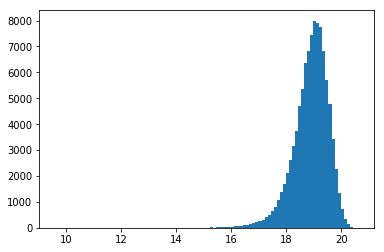

In [70]:
plt.hist(m_vals[0,:],bins=100)
plt.show()

In [83]:
mlims = np.linspace(15,27,100)

In [84]:
sum(np.array([sum(m_vals[0,:]>=mlim)/100000 for mlim in mlims]))

73.76023999999997

In [72]:
quad(p_d_f[0].pdf,kne_inf.dlim(19,-17),np.inf)[0]

0.47582680522742044

In [20]:
m_low = 15
m_high = 27
mlims_f_j = np.array([np.array([np.array([22,26,26]),np.array([19,22,22,22])]),np.array([np.array([21,23,23])])])
f_bar_sum = np.array(list(map(compute_f_bar_sum,mlims_f_j)))
t0 = np.array([1.,1.])
T_f_j = np.array([[(np.linspace(t0[0],t0[0]+4,3)),(np.linspace(t0[0],t0[0]+4,4))],[(np.linspace(t0[1],t0[1]+4,3))]])
P_f = np.array([[0.1,0.89],[0.6]])
p_d_f = np.array([[kne_inf.create_distance_dist(156,41),kne_inf.create_distance_dist(156,41)],[kne_inf.create_distance_dist(160,41)]])
P_A= np.array([1.,0.7])
P_T = 1-P_A

In [175]:
M_f_j = np.array([kne_inf.lc_model(-14,0.8,t_0=t0,t=t_j).value for t_j in T_f_j])
dlims_f_j = np.array(list(map(kne_inf.dlim,mlims_f_j,M_f_j)))
pmlims_f_j = np.array(list(map(np.vectorize(kne_inf.create_mlim_pdf),mlims_f_j,M_f_j,p_d_f,m_low_arr,m_high_arr)))
pmlims_f = np.array([np.product(p) for p in pmlims_f_j])*P_f*1/(m_high-m_low)**f_bar_sum

In [176]:
p_den_j = np.array(list(map(lambda M: quad(lambda m: quad(p_d_f[0].pdf,kne_inf.dlim(m,M),np.inf)[0],m_low,m_high)[0],M_f_j[0])))

In [177]:
p_den_j

array([ 6.8803028 , 11.99110086, 11.99926728, 11.99966889])

In [179]:
pmlims_f[0]/2/np.product(p_den_j),pmlims_f[1]*3/np.product(p_den_j)

(7.703910080104154e-10, 2.1928654605521076e-09)

In [151]:
pmlims_f_j,pmlims_f*P_A,plims_f_bar*P_A,plims_T

(array([[0.98834312, 0.38281512, 0.85623101, 0.95389576],
        [0.99777148, 0.00348802, 0.29452369, 0.67086961]]),
 array([1.19221259e-05, 6.63243799e-09]),
 0.0,
 2.3256803936137784e-09)

In [64]:
pmlims_f_j,pmlims_f*P_A,plims_f_bar*P_A,plims_T*P_T

(array([[0.98834312, 0.99971324, 0.99992752, 0.99995704],
        [0.99975587, 0.99997823, 0.99999147, 0.9999944 ]]),
 array([2.38219920e-06, 4.58012147e-05]),
 0.0,
 0.0)

## P_A=1 - Two competing fields - (0.5,0.8,1.0)

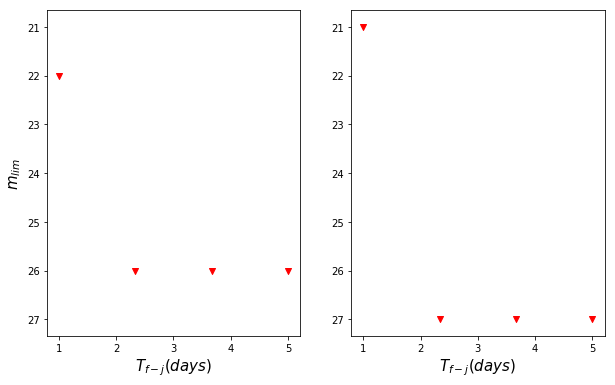

In [35]:
plt.figure(figsize=(10,6))
ax1=plt.subplot(121)
plt.scatter(T_f_j[0],mlims_f_j[0],marker='v',c='r')
plt.ylabel(r'$m_{lim}$',fontsize=15)
plt.xlabel(r'$T_{f-j} (days)$',fontsize=15)
plt.subplot(122,sharey=ax1)
plt.scatter(T_f_j[1],mlims_f_j[1],marker='v',c='r')
plt.xlabel(r'$T_{f-j} (days)$',fontsize=15)
plt.gca().invert_yaxis()
plt.show()

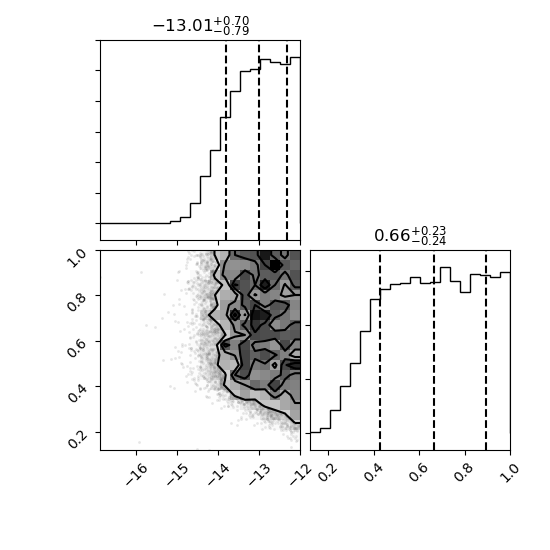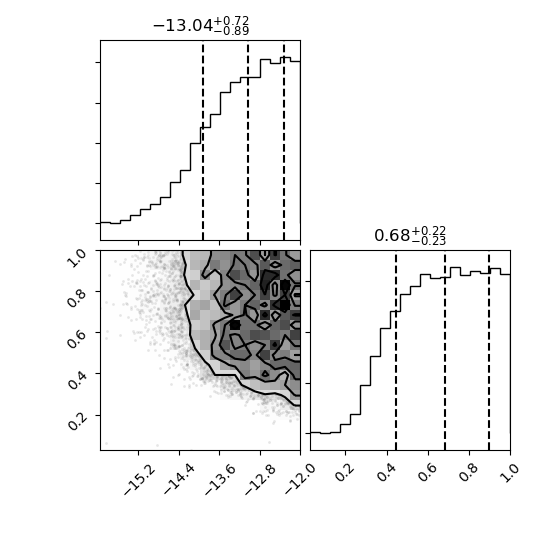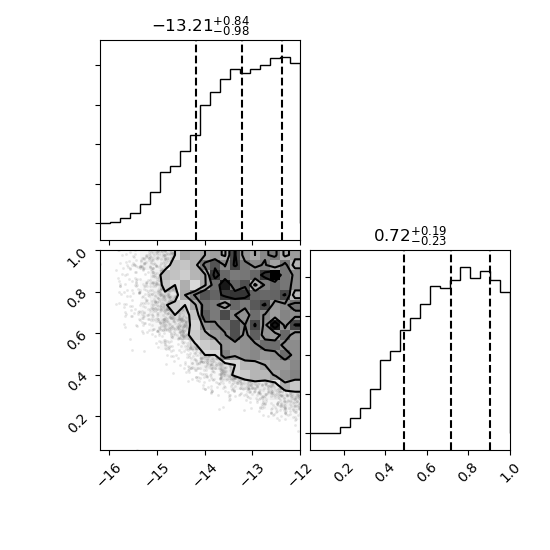

## P_A=1 - Vary field probability - (0.2,0.5,0.8,1.0)

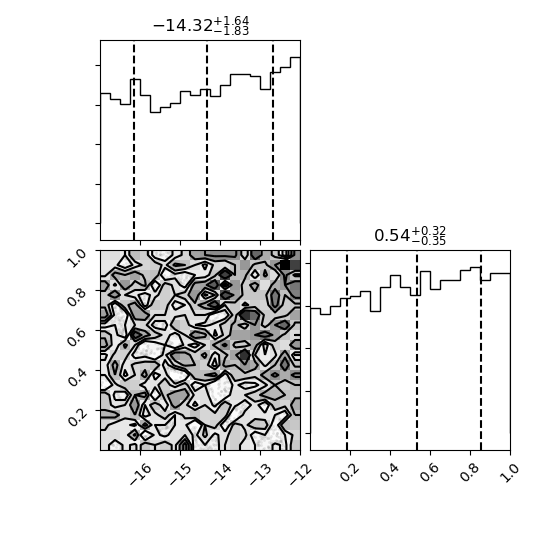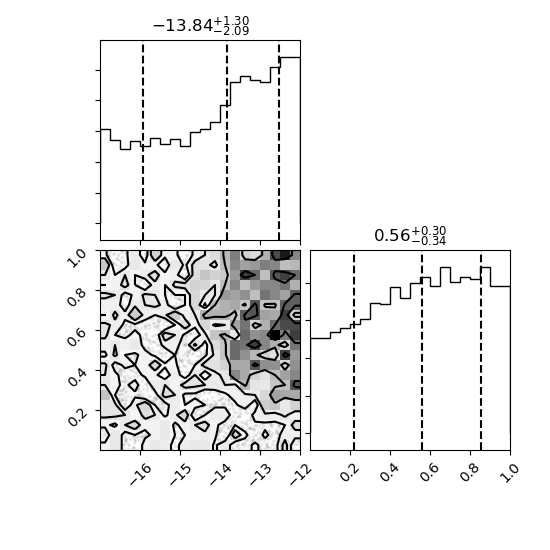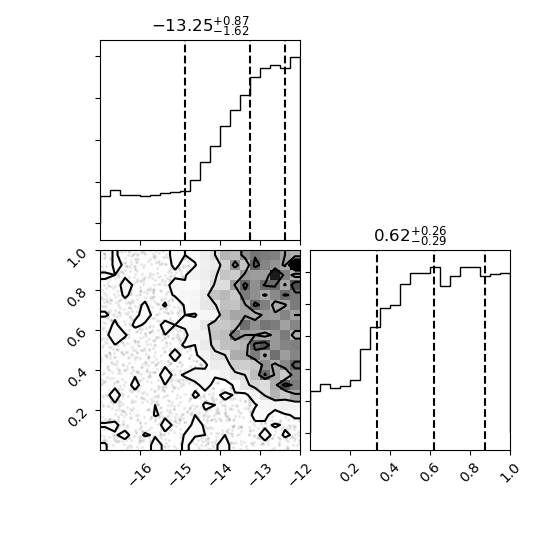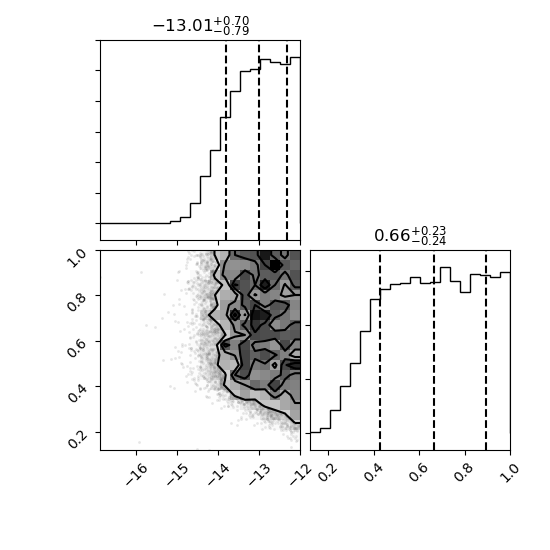

## Vary P_A - (0.8,1.0)

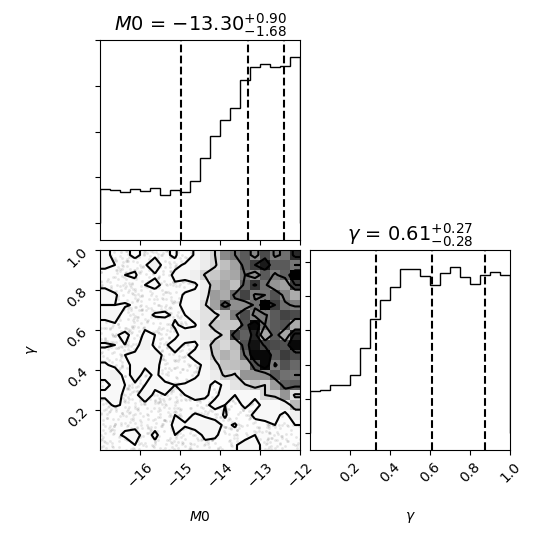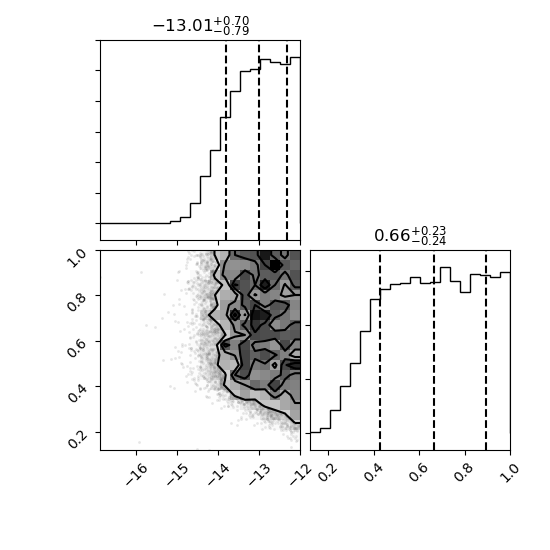